# Loading the data

Load the training and test data, both of the dataset is balanced. 'Class Index' column represents the classes

* 1 represents "world news"
* 2 represents "sports news"
* 3 represents "business news"
* 4 represents "science technology news"



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import html
from bs4 import BeautifulSoup

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
def clean_text(text):
    # Decode HTML entities
    #text = html.unescape(text)

    # Remove all <a> tags and their content (links)
    soup = BeautifulSoup(text, "html.parser")
    for a_tag in soup.find_all('a'):
        a_tag.decompose()  # Removes the <a> tag completely

    # Extract the cleaned text
    cleaned_text = soup.get_text()

    # Optionally, remove extra spaces and unwanted characters
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    # Remove backslashes
    cleaned_text = re.sub(r'\\', ' ', cleaned_text)

    # Explicitly replace #39; with an apostrophe and remove space before 's
    cleaned_text = re.sub(r'#39;', "'", cleaned_text)
    cleaned_text = re.sub(r"\s+'s", "'s", cleaned_text)

    cleaned_text = re.sub(r'#36;', '$', cleaned_text)

    return cleaned_text

In [4]:
train_data['raw_text'] = train_data['Title'] + '. ' + train_data['Description']
train_data['labels'] = train_data['Class Index'] - 1 # did this for the distBERT model
train_data['text'] = train_data['raw_text'].apply(clean_text)
train_data.drop(['Title', 'Description', 'raw_text', 'Class Index'], inplace=True, axis=1)
train_data.head()

/var/folders/xy/dx7jchm93_3g0v9knvqprvz80000gn/T/ipykernel_2874/3327050546.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


,labels,text
0,2,Wall St. Bears Claw Back Into the Black (Reute...
1,2,Carlyle Looks Toward Commercial Aerospace (Reu...
2,2,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,2,Iraq Halts Oil Exports from Main Southern Pipe...
4,2,"Oil prices soar to all-time record, posing new..."


In [5]:
# Note that test data is balanced as well, 1900 samples from each class
test_data['raw_text'] = test_data['Title'] + '. ' + test_data['Description']
test_data['labels'] = test_data['Class Index'] - 1
test_data['text'] = test_data['raw_text'].apply(clean_text)
test_data.drop(['Title', 'Description', 'raw_text', 'Class Index'], inplace=True, axis=1)
test_data.head()

/var/folders/xy/dx7jchm93_3g0v9knvqprvz80000gn/T/ipykernel_2874/3327050546.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


,labels,text
0,2,Fears for T N pension after talks. Unions repr...
1,3,The Race is On: Second Private Team Sets Launc...
2,3,Ky. Company Wins Grant to Study Peptides (AP)....
3,3,Prediction Unit Helps Forecast Wildfires (AP)....
4,3,Calif. Aims to Limit Farm-Related Smog (AP). A...


# Traditional Baseline Models

In [6]:
x_train, y_train = train_data['text'], train_data['labels']
x_test, y_test = test_data['text'], test_data['labels']

## Naive Bayes Classifier

Accuracy (test data) = 0.9009
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.90      1900
           1       0.95      0.98      0.96      1900
           2       0.88      0.84      0.86      1900
           3       0.86      0.89      0.88      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600



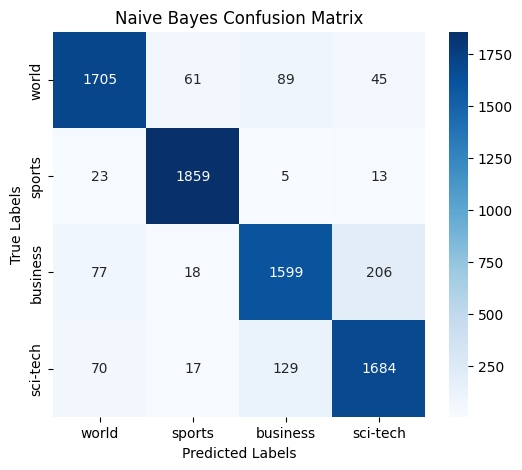

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

clf = make_pipeline(
    CountVectorizer(), # vectorize the speeches
    MultinomialNB() # fit Naive Bayes model
)

clf.fit(x_train, y_train)
y_pred_nb = clf.predict(x_test)
acc_nb= np.mean(y_test == y_pred_nb)
print(f"Accuracy (test data) = {acc_nb:.4f}")
print("Classification report:\n", classification_report(y_test, y_pred_nb))

cm_nb = confusion_matrix(y_test, y_pred_nb, labels=[0,1,2,3])
plt.figure(figsize=(6, 5))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=["world", "sports", "business", "sci-tech"], yticklabels=["world", "sports", "business", "sci-tech"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Naive Bayes Confusion Matrix')
plt.show()

## Logistic Regression Model

Accuracy (test data) = 0.9167
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92      1900
           1       0.95      0.98      0.97      1900
           2       0.89      0.88      0.89      1900
           3       0.89      0.90      0.89      1900

    accuracy                           0.92      7600
   macro avg       0.92      0.92      0.92      7600
weighted avg       0.92      0.92      0.92      7600



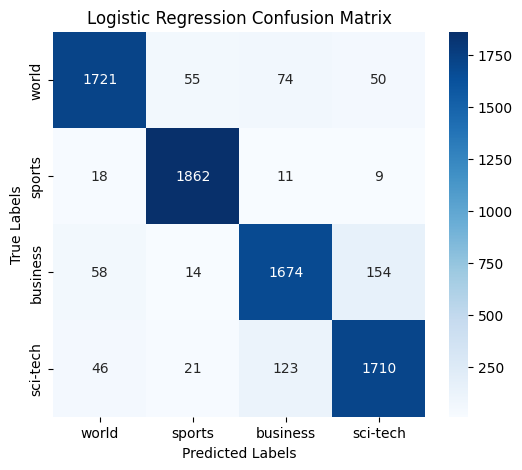

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

x_train, y_train = train_data['text'], train_data['labels']
x_test, y_test = test_data['text'], test_data['labels']

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Transform the text data
x_train_tfidf = vectorizer.fit_transform(x_train)
x_test_tfidf = vectorizer.transform(x_test)

model_logistic = LogisticRegression(max_iter=500) # check the parameters
model_logistic.fit(x_train_tfidf, y_train)

y_pred_log = model_logistic.predict(x_test_tfidf)

acc_logistic = np.mean(y_test == y_pred_log)
print(f"Accuracy (test data) = {acc_logistic:.4f}")
print("Classification report:\n", classification_report(y_test, y_pred_log))

cm_logistic = confusion_matrix(y_test, y_pred_log, labels=[0,1,2,3])
cm_logistic
plt.figure(figsize=(6, 5))
sns.heatmap(cm_logistic, annot=True, fmt='d', cmap='Blues', xticklabels=["world", "sports", "business", "sci-tech"], yticklabels=["world", "sports", "business", "sci-tech"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Logistic Regression Confusion Matrix')
plt.show()